# Quantum Kernel Evaluation via Hong-Ou-Mandel Interference

In [2]:
import math
import numpy as np
from sklearn.datasets import make_classification, make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
import itertools as it
import numpy as np


plt.rcParams.update({'font.size': 24})
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'


# Generate Data

In [256]:
#Create data 

N=2
Nsamples = 1000
Nfeatures= 2

centers =  [[0.6, 0.5], [0.6, -0.52], [-0.5, -0.5], [-0.5,0.5]]
random_state = 4
cluster_std = 0.3

X, Y = make_blobs(n_samples=Nsamples, n_features=Nfeatures,
                  centers=centers,
                  random_state=random_state,
                  cluster_std=cluster_std)



# Make some test data from same specifications 
Ntest = 1000
Xtest, Ytest = make_blobs(n_samples=Ntest, n_features=Nfeatures,
                  centers=centers,
                  random_state=random_state,
                  cluster_std=cluster_std)






[0.06728143 0.00604072]
[ 0.05230714 -0.00362701]


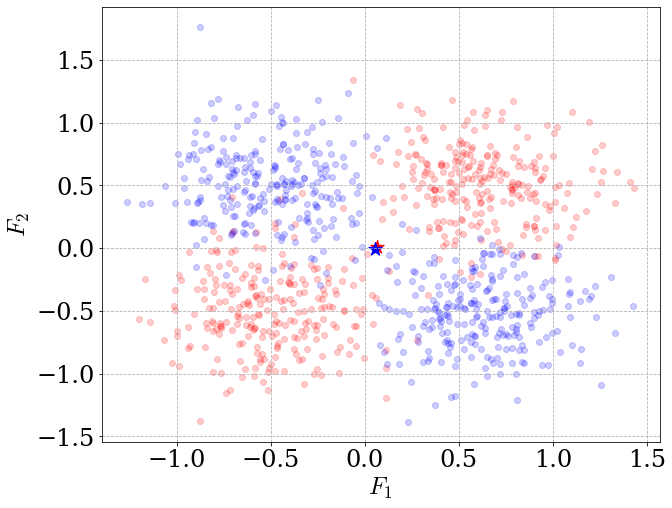

In [342]:
#Visualise Data 

#define category groups 
y0 = np.where(Y == 0)
y1 = np.where(Y == 1)
y2 = np.where(Y == 2)
y3 = np.where(Y == 3)

# Classify data points
X_0g = np.append(X[y0],X[y2],axis=0)
X_1g = np.append(X[y1],X[y3],axis=0)

#Generate Means
X_0g_mean = np.mean(X_0g, axis=0)
X_1g_mean = np.mean(X_1g, axis=0)

A=0
B=1

fig = plt.figure(figsize=(10, 8))

plt.scatter(X_0g[:,A], X_0g[:,B], color='r', alpha=0.2)
plt.scatter(X_1g[:,A], X_1g[:,B], color='b', alpha=0.2)
plt.scatter(X_0g_mean[A], X_0g_mean[B], color='r', marker='*', s=200)
plt.scatter(X_1g_mean[A], X_1g_mean[B], color='b', marker='*', s=200)
plt.grid(True, linestyle='--')
plt.ylabel(r'$F_2$')
plt.xlabel(r'$F_1$')

fig.savefig('example.png', bbox_inches='tight', dpi=150)

print(X_0g_mean)
print(X_1g_mean)

In [258]:
#Define Second Degree Polynomial Vector 
def poly2(mean):
    N=len(mean)
    out =[]
    for i in range(N):
        out.append(0.5*mean[i]**2)
    for i in range(N-1):
        for j in np.arange(i+1,N):
            out.append(2**(-0.5)*(mean[i]*mean[j]))
    return np.array(out)

print(poly2(X_0g_mean))
print(poly2(X_1g_mean))

[2.26339528e-03 1.82451550e-05 2.87388231e-04]
[ 1.36801829e-03  6.57761114e-06 -1.34151350e-04]


In [259]:
#Transform data to feature space and normalise 

M = len(poly2(X_0g[0]))

X_0=np.zeros(((len(X_0g)), M))
for i in range(len(X_0g)):
    X_0[i] = poly2(X_0g[i])

X_1=np.zeros(((len(X_1g)), M))
for i in range(len(X_1g)):
    X_1[i] = poly2(X_1g[i])

#Get Normalised Averages 
Xavg0g = np.mean(X_0, axis=0)
Xavg0 = Xavg0g/np.linalg.norm(Xavg0g)
Xavg1g = np.mean(X_1, axis=0) 
Xavg1 = Xavg1g/np.linalg.norm(Xavg1g)


#Transform test data to feature space and normalise 

#define category groups 
ytest0 = np.where(Ytest == 0)
ytest1 = np.where(Ytest == 1)
ytest2 = np.where(Ytest == 2)
ytest3 = np.where(Ytest == 3)

# Classify data points
X_test_0g = np.append(Xtest[ytest0],Xtest[ytest2],axis=0)
X_test_1g = np.append(Xtest[ytest1],Xtest[ytest3],axis=0)

X_test_0=np.zeros(((len(X_test_0g)), M))
for i in range(len(X_test_0g)):
    X_test_0[i] = poly2(X_test_0g[i])/np.linalg.norm(poly2(X_test_0g[i]))

X_test_1=np.zeros(((len(X_test_1g)), M))
for i in range(len(X_test_1g)):
    X_test_1[i] = poly2(X_test_1g[i])/np.linalg.norm(poly2(X_test_1g[i]))
    


In [330]:
# X_0.T[0]

X_test_0

array([[ 0.56947416,  0.43052584,  0.70024759],
       [ 0.13260534,  0.86739466,  0.47962728],
       [ 0.99192316,  0.00807684, -0.12658283],
       ...,
       [ 0.17797003,  0.82202997,  0.54091904],
       [ 0.15053747,  0.84946253,  0.50571917],
       [ 0.3973287 ,  0.6026713 ,  0.69203845]])

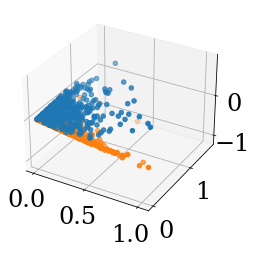

In [311]:
ax = plt.figure().add_subplot(projection='3d')

ax.scatter(X_0.T[0],X_0.T[1],X_0.T[2], label='points in (x, z)')
ax.scatter(X_1.T[0],X_1.T[1],X_1.T[2], label='points in (x, z)')


In [260]:
#Define Maximum Mean discrepancy calculation
def MMD(mean_1, mean_2):
    
    MMD = np.linalg.norm(mean_1 - mean_2)**2
    return MMD

def MMD2(mean_1, mean_2):
    return 2*(1-np.abs(np.dot(mean_1, np.conj(mean_2)))**2)

In [261]:
# Calculating the gradient in the cost function (MMD)
def Grad_SGD(XM0, XM1, wN, wM):
    
    #XM0 is the mean of class0 
    #XM1 is the mean of class 1
    # wN is current weight
    # wM is previous weight

    f0m = np.multiply(wM,XM0)/np.linalg.norm(np.multiply(wM,XM0))
    f1m = np.multiply(wM,XM1)/np.linalg.norm(np.multiply(wM,XM1))
    f0n = np.multiply(wN,XM0)/np.linalg.norm(np.multiply(wN,XM0))
    f1n = np.multiply(wN,XM1)/np.linalg.norm(np.multiply(wN,XM1))
    
    f = np.sqrt(MMD2(f0n, f1n))
    Δf = f - np.sqrt(MMD2(f0m, f1m))
    Δw = wN - wM

    return 2*np.sqrt(f) * (Δf/Δw)



In [262]:
#Define a function to update weight values based on a stochastic gradient decent with momentum

def train_SGD(XM0, XM1, L, w0, ϵ):
    
    # L is step size
    N = len(XM0)
    
    # Initialise random weights and arrays
    w = []
    Cost = 0
    trackcost=[]
    w.append(w0)

    w.append(w[0] + np.random.normal(0, 1, N)*L)

    while (Cost < 1.995) and (len(w) < 10000):
        
        XM0cof = np.multiply(w[-2],XM0)/np.linalg.norm(np.multiply(w[-2],XM0))
        XM1cof = np.multiply(w[-2],XM1)/np.linalg.norm(np.multiply(w[-2],XM1))
        
        Cost = MMD2(XM0cof, XM1cof)
        trackcost.append(Cost)
        
        # Compute cost function
        # Cost[i] = MMD(nsphere(XM0, w[i-1]), nsphere(XM1, w[i-1]))
        
        ΔC = Grad_SGD(XM0, XM1, w[-1], w[-2])
        
        if Cost < 0.1:
            w.append(w[np.argmax(Cost)] + np.random.normal(0, 1, N)*L)
        elif Cost <1.8:
            if np.all(w[-1] == w[-2]):
                w.append(w + 10*np.random.normal(0, 1, N)*L)
            else:
                w.append(w[-1] + (ΔC*L*10) + 10*ϵ*(0.5-np.random.rand( N)))
        elif 1.8 < Cost < 1.9:
            if np.all(w[-1] == w[-2]):
                w.append(w + 0.1*np.random.normal(0, 1, N)*L)
            else:
                w.append(w[-1] + (ΔC*0.1*L) + 0.1*ϵ*(0.5-np.random.rand(N)))
        elif 1.9 < Cost:
            if np.all(w[-1] == w[-2]):
                w.append(w + 0.01*np.random.normal(0, 1, N)*L)
            else:
                w.append(w[-1] + (ΔC*0.01*L) + 0.01*ϵ*(0.5-np.random.rand(N)))
            
    return w, trackcost


In [263]:
#define Hermite Polynomials 
from scipy import special

def Psin(omega, n):
    
    # Get hermite polynomial
    Hn = special.hermite(n)
    
    return np.exp(-omega**2 / 2)/(np.pi**(1/4) * (2**n * factorial(n))**(1/2)) * Hn(omega)

def HOM(t, dt, Dt, psi0, psi1, d):
    
    '''
    t: time array 
    dt: timestep
    Dt: relative time difference between modes
    psi0: coefficients of the first state of dimension d
    psi1: coefficients of the second state of dimension d
    d: dimesnion of subspaces
    '''
    
    Psi1 = np.array([psi0[n]*Psin(t, n) for n in range(d)], dtype=complex)
    Psi2 = np.array([psi1[n]*Psin(t+Dt, n) for n in range(d)], dtype=complex)
    
    prod = np.abs(np.sum(np.conjugate(Psi1)*Psi2)*dt)**2
    
    return 1-prod

Dtvals = np.linspace(-5,5, 500)

In [278]:
# Unit weights
# w0 = np.ones(len(Xavg0))
w0 = np.random.normal(1, 0.1, (len(Xavg0)))
w1 = w0 + np.random.normal(0, 0.1, (len(Xavg0)))

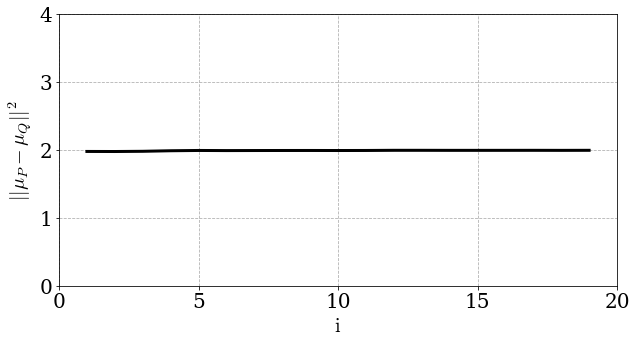

1.9420385634036221
1.995554479506492
[1.78940931 1.84745866 2.50600002]


In [290]:
# Set Learning rate
L = 1
ϵ = L

# Train algorithm
[w, Cost] = train_SGD(Xavg0, Xavg1, L, w0, ϵ)

# Plot Cost function
ap = 0.1
sz = 500
fs = 20

epoch_graph = range(1, len(Cost)-1)

plt.figure(figsize=(10,5))
plt.plot(epoch_graph, Cost[1:-1], color='k', linewidth=3)


plt.xlim([0, len(Cost)-1])

plt.grid(True, linestyle='--')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylabel(r'$|| \mu_{P} - \mu_{Q}||^{2}$', fontsize=fs)
plt.xlabel(r'$\mathrm{i}$', fontsize=fs)

plt.ylim([0,4])

plt.show()
print(Cost[0])
print(Cost[-1])
print(w[-1])

# Visualise Fock State

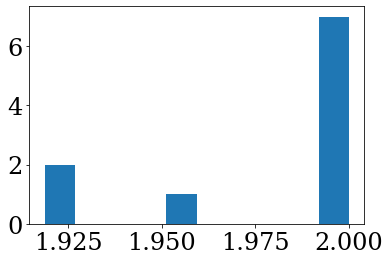

In [291]:
avgcost = []
samples = 10
for i in range(samples):
    [w, Cost] = train_SGD(Xavg0, Xavg1, L, w0, ϵ)
    avgcost.append(Cost[-1])


plt.hist(avgcost)
plt.show()

In [292]:
a=0
for i in range(samples):
    if 1.99 < avgcost[i]:
        a=a+1
print(a)

b=0
for i in range(samples):
    if 1.9 < avgcost[i]:
        b=b+1
        
c=0
for i in range(samples):
    if 1.86 < avgcost[i]:
        c=c+1
print(b)
print(c)
print(min(avgcost))

7
10
10
1.9187318257327926


In [293]:
# Compute normalised coefficients for our states 
X0before = X_0g_mean/np.linalg.norm(X_0g_mean).astype(complex)
X0before[N-1] = complex(0,X0before[N-1])
X1before = X_1g_mean/np.linalg.norm(X_1g_mean).astype(complex)
X1before[N-1] = complex(0,X1before[N-1])



X0after = np.multiply(w[-1],Xavg0)/np.linalg.norm(np.multiply(w[-1],Xavg0)).astype(complex)
X0after[M-1] = complex(0,X0after[M-1])
X1after =np.multiply(w[-1],Xavg1)/np.linalg.norm(np.multiply(w[-1],Xavg1)).astype(complex)
X1after[M-1] = complex(0,X1after[M-1])



array([0.99599372+0.j        , 0.        +0.08942319j])

In [294]:
print('Overlap of means before training =', np.round(np.abs(np.dot(X0before, np.conj(X1before)))**2,3))
print('Overlap of means after training =', np.round(np.abs(np.dot(X0after, np.conj(X1after)))**2,3))

Overlap of means before training = 0.975
Overlap of means after training = 0.023


In [295]:
# Demonstration of Fock modes Before and After 
factorial = np.math.factorial

t0 = -10
t1 = -t0
dt = 0.01
t = np.arange(t0, t1, dt)
dt = t[1]-t[0]


#Define Fock modes before training 
P0b = np.sum(np.array([coef*Psin(t, n) for n, coef in enumerate(X0before)], dtype=complex), axis=0)
P1b = np.sum(np.array([coef*Psin(t, n) for n, coef in enumerate(X1before)], dtype=complex), axis=0)

# Define Fock modes after training
P0A = np.sum(np.array([coef*Psin(t, n) for n, coef in enumerate(X0after)], dtype=complex), axis=0)
P1A = np.sum(np.array([coef*Psin(t, n) for n, coef in enumerate(X1after)], dtype=complex), axis=0)

# Compute Overlap 
OB = np.abs(np.sum(P0b*np.conj(P1b))*dt)**2
OA = np.abs(np.sum(P0A*np.conj(P1A))*dt)**2

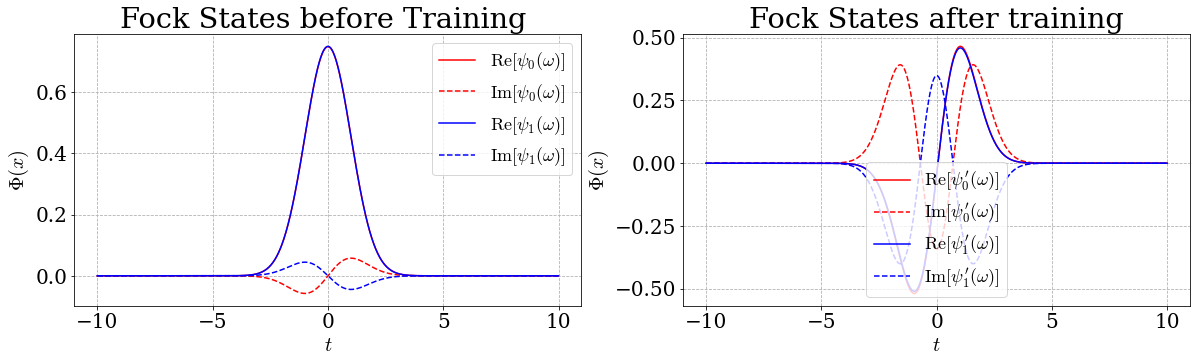

In [296]:
#Plot Fock States before and After training 

fs = 20

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(t, np.real(P0b) ,'r', label=r'$\mathrm{Re}[\psi_{0}(\omega)]$')
plt.plot(t, np.imag(P0b), 'r--',  label=r'$\mathrm{Im}[\psi_{0}(\omega)]$')

plt.plot(t, np.real(P1b) ,'b',  label=r'$\mathrm{Re}[\psi_{1}(\omega)]$')
plt.plot(t, np.imag(P1b), 'b--',  label=r'$\mathrm{Im}[\psi_{1}(\omega)]$')

plt.xlabel(r'$ t$', fontsize=fs)
plt.ylabel(r'$\Phi(x)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=18)
plt.title('Fock States before Training ')
plt.grid(True, linestyle='--')

plt.subplot(1, 2, 2)
plt.plot(t, np.real(P0A) ,'r', label=r"$\mathrm{Re}[\psi_{0}'(\omega)]$")
plt.plot(t, np.imag(P0A), 'r--', label=r"$\mathrm{Im}[\psi_{0}'(\omega)]$")

plt.plot(t, np.real(P1A) ,'b', label=r"$\mathrm{Re}[\psi_{1}'(\omega)]$")
plt.plot(t, np.imag(P1A), 'b--', label=r"$\mathrm{Im}[\psi_{1}'(\omega)]$")

plt.xlabel(r'$ t$', fontsize=fs)
plt.ylabel(r'$\Phi(x)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=18)
plt.title('Fock States after training')
plt.grid(True, linestyle='--')

plt.show()

# Transform Test Data to perform Classification

In [297]:
#All data before
X_0_before=np.zeros(((len(X_test_0g)), N),dtype=complex)
for i in range(len(X_test_0g)):
    X_0_before[i] = X_test_0g[i]/np.linalg.norm(X_test_0g[i])
    X_0_before[i,N-1] = complex(0,X_0_before[i,N-1])

X_1_before=np.zeros(((len(X_test_1g)), N), dtype=complex)
for i in range(len(X_test_1g)):
    X_1_before[i] = X_test_1g[i]/np.linalg.norm(X_test_1g[i])
    X_1_before[i,N-1] = complex(0,X_1_before[i,N-1])

#All data afterwards 
X_0_after=np.zeros(((len(X_test_0)), M),dtype=complex)
for i in range(len(X_test_0)):
    X_0_after[i] = np.multiply(w[-1],X_test_0[i])/np.linalg.norm(np.multiply(w[-1],X_test_0[i]))
    X_0_after[i,M-1] = complex(0,X_0_after[i,M-1])
    
X_1_after=np.zeros(((len(X_test_1)), M), dtype=complex)
for i in range(len(X_test_1)):
    X_1_after[i] = np.multiply(w[-1],X_test_1[i])/np.linalg.norm(np.multiply(w[-1],X_test_1[i]))
    X_1_after[i,M-1] = complex(0,X_1_after[i,M-1])
    



(500, 3)

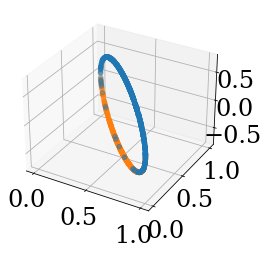

In [339]:
tt = X_test_0.T
tt2 = X_test_1.T

# ff = np.abs(X_

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(tt[0], tt[1], tt[2], label='points in (x, z)')
ax.scatter(tt2[0], tt2[1], tt2[2], label='points in (x, z)')

# ax.

np.shape(X_0_after)

# Compute Coincidence counts

In [298]:
# We now go and compute the HOM dip value for each of our ants and bees data point

X0dipB = 1-np.array([np.abs(np.dot(X1before, np.conj(x0)))**2 for x0 in X_0_before])
X1dipB = 1-np.array([np.abs(np.dot(X1before, np.conj(x1)))**2 for x1 in X_1_before])

X0dipAa = np.array([np.abs(np.dot(X0after, np.conj(x0)))**2 for x0 in X_0_after])
X1dipAa = np.array([np.abs(np.dot(X0after, np.conj(x1)))**2 for x1 in X_1_after])


X0dipA = np.array([np.abs(np.dot(X0after, np.conj(x0)))**2 for x0 in X_0_after])
X1dipA = np.array([np.abs(np.dot(X0after, np.conj(x1)))**2 for x1 in X_1_after])

# X0dipAa = np.array([np.abs(np.dot(X1after, np.conj(x0)))**2 for x0 in X_0_after])
# X1dipAa = np.array([np.abs(np.dot(X0after, np.conj(x1)))**2 for x1 in X_1_after])

# CC before
CCb = np.array([HOM(t, dt, Dt, X0before, X1before, N) for Dt in Dtvals])

# CC after
CCa = np.array([HOM(t, dt, Dt, X0after, X1after, M) for Dt in Dtvals])

# Determine Classification Bounds 

In [299]:
boundb=0.5

max_A=1-np.round(np.abs(np.dot(X0after, np.conj(X1after)))**2,3)

#Generate Similarity measures for training data 
X_1_train=np.zeros(((len(X_1)), M), dtype=complex)
for i in range(len(X_1)):
    X_1_train[i] = np.multiply(w[-1],X_1[i])/np.linalg.norm(np.multiply(w[-1],X_1[i]))
    X_1_train[i,M-1] = complex(0,X_1_train[i,M-1])
    

X1diptest = 1-np.array([np.abs(np.dot(X1after, np.conj(x1)))**2 for x1 in X_1_train])

min_A = np.min(X1diptest)
bounda=max_A-((max_A-min_A)/2)


In [313]:
X_1_train[0]

array([-0.02935251+0.j        ,  0.78307557+0.j        ,
        0.        -0.62123351j])

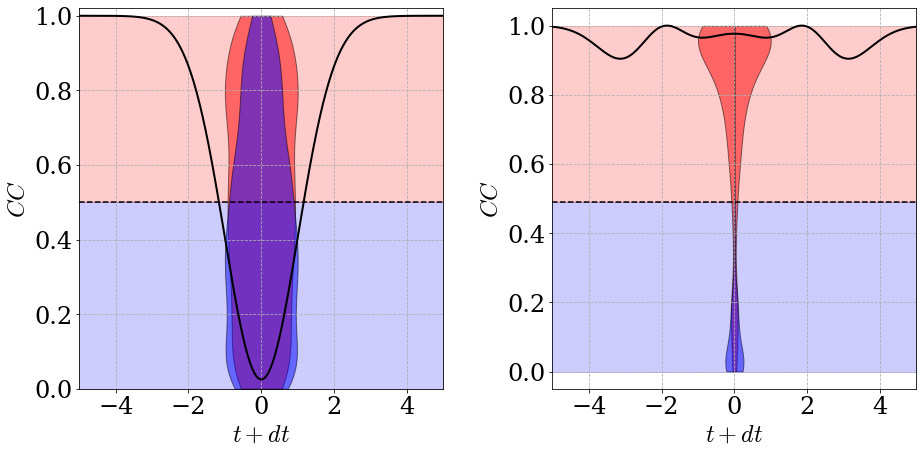

In [300]:
ap = 0.2
sz = 500
fs = 20
wid = 2

# Let's plot the data
plt.figure(figsize=(15,7))

# Subplot 1
plt.subplot(1, 2, 1)

plt.plot(Dtvals, CCb, color='k', linewidth=2)
plt.hlines(boundb ,-5, 5, color='k', linestyle='--')

plt.fill_between(np.linspace(-5, 5, 100), 0, boundb, color='b', alpha=ap)
plt.fill_between(np.linspace(-5, 5, 100), boundb, 1, color='r', alpha=ap)

# Add violin plot
v1 = plt.violinplot(X0dipB, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipB, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

plt.xlabel(r'$t+dt$', fontsize=24)
plt.ylabel(r'$CC$', fontsize=24)
# plt.title(r'Violin Plot before Training', fontsize=30)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim([np.min(Dtvals), np.max(Dtvals)])
plt.ylim([0,1.02])
plt.grid(True, linestyle='--')

plt.subplot(1, 2, 2)

plt.plot(Dtvals, CCa, color='k', linewidth=2)
plt.hlines(bounda ,-5, 5, color='k', linestyle='--')

plt.fill_between(np.linspace(-5, 5, 100), 0, bounda, color='b', alpha=ap)
plt.fill_between(np.linspace(-5, 5, 100), bounda, 1, color='r', alpha=ap)

v1 = plt.violinplot(X0dipA, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipA, [0], widths= wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

plt.xlabel(r'$t+dt$', fontsize=24)
plt.ylabel(r'$CC$', fontsize=24)
#plt.title(r'Violin Plot after Training', fontsize=30)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.xlim([np.min(Dtvals), np.max(Dtvals)])
# plt.ylim([0,1.02])
plt.grid(True, linestyle='--')

plt.subplots_adjust(wspace=0.3, hspace=0)

plt.show()

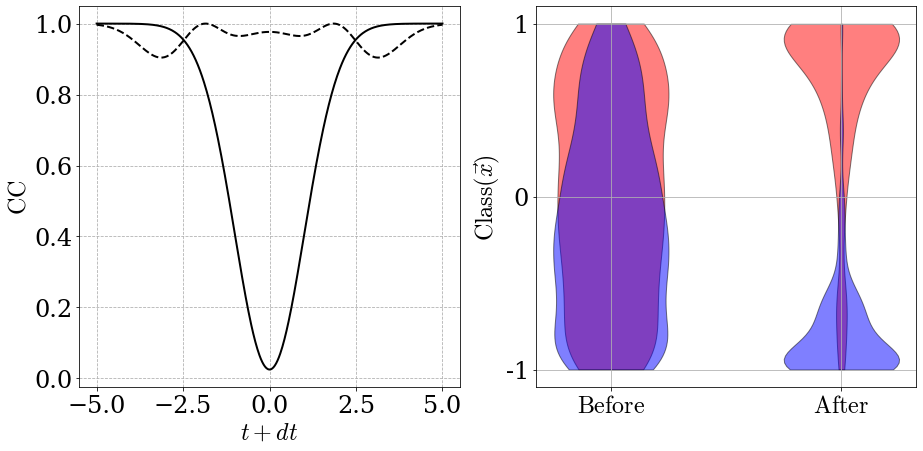

In [348]:
plt.figure(figsize=(15,7))

# Subplot 1
plt.subplot(1, 2, 1)

plt.plot(Dtvals, CCb, color='k', linewidth=2)
plt.plot(Dtvals, CCa, color='k', linewidth=2, linestyle='--')
plt.ylabel(r'$\mathrm{CC}$', fontsize=24)
plt.xlabel(r'$t+dt$', fontsize=24)

plt.grid(linestyle='--')

plt.subplot(1, 2, 2)

v1 = plt.violinplot(X0dipB, [-2], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipB, [-2], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

    
v1 = plt.violinplot(X0dipA, [2], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipA, [2], widths= wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
plt.xticks([])
plt.ylabel(r'$\mathrm{Class}(\vec{x})$', fontsize=24)
plt.xticks([-2, 2], [r'${\rm Before}$', r'${\rm After}$'], fontsize=24)


plt.yticks([0, 0.5, 1],[-1,0,1])

plt.grid()
plt.show()

# Confusion Matrix

In [302]:
from sklearn.metrics import confusion_matrix

y_pred_before = []
y_class_before = []

for i in range(len(X0dipB)):
    y_class_before.append(0)
    if X0dipB[i] > boundb:
        y_pred_before.append(0)
    else:
        y_pred_before.append(1)
        
for i in range(len(X1dipB)):
    y_class_before.append(1)
    if X1dipB[i] > boundb:
        y_pred_before.append(0)
    else:
        y_pred_before.append(1)
        
CMbefore = (confusion_matrix(y_class_before, y_pred_before))/(Nsamples/2)


y_pred_after = []
y_class_after = []

for i in range(len(X0dipA)):
    y_class_after.append(0)
    if X0dipA[i] > bounda:
        y_pred_after.append(0)
    else:
        y_pred_after.append(1)
        
for i in range(len(X1dipA)):
    y_class_after.append(1)
    if X1dipA[i] > bounda:
        y_pred_after.append(0)
    else:
        y_pred_after.append(1)
        
CMafter = (confusion_matrix(y_class_after, y_pred_after))/(Nsamples/2)




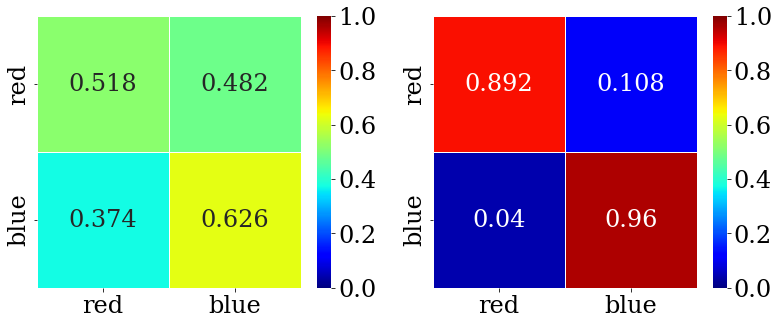

In [303]:
import seaborn as sns



vmin, vmax = 0.0, 1
cmap = 'jet'

x_axis_labels = ["red", "blue"] # labels for x-axis
y_axis_labels = ["red", "blue"] # labels for y-axis


fig = plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(CMbefore,
                  xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                  cmap=cmap, 
                  annot=True, linewidth=0.5,
                  vmin=vmin, vmax=vmax,
                  fmt='.3g')

#ax1.title.set_text('CM before Training')
ax1.title.set_size(24)
#plt.xlabel('True Classifiction', fontsize = 15) # x-axis label with fontsize 15
#plt.ylabel('Calculated Classification', fontsize = 15) # y-axis label with fontsize 15

plt.subplot(1, 2, 2)
ax1 = sns.heatmap(CMafter,
                  xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                  cmap=cmap, 
                  annot=True, linewidth=0.5,
                  vmin=vmin, vmax=vmax,
                  fmt='.3g')

# ax1.title.set_text('CM after Training')
# ax1.title.set_size(24)
# plt.xlabel('True Classifiction', fontsize = 15) # x-axis label with fontsize 15
# plt.ylabel('Calculated Classification', fontsize = 15) # y-axis label with fontsize 15

plt.show()

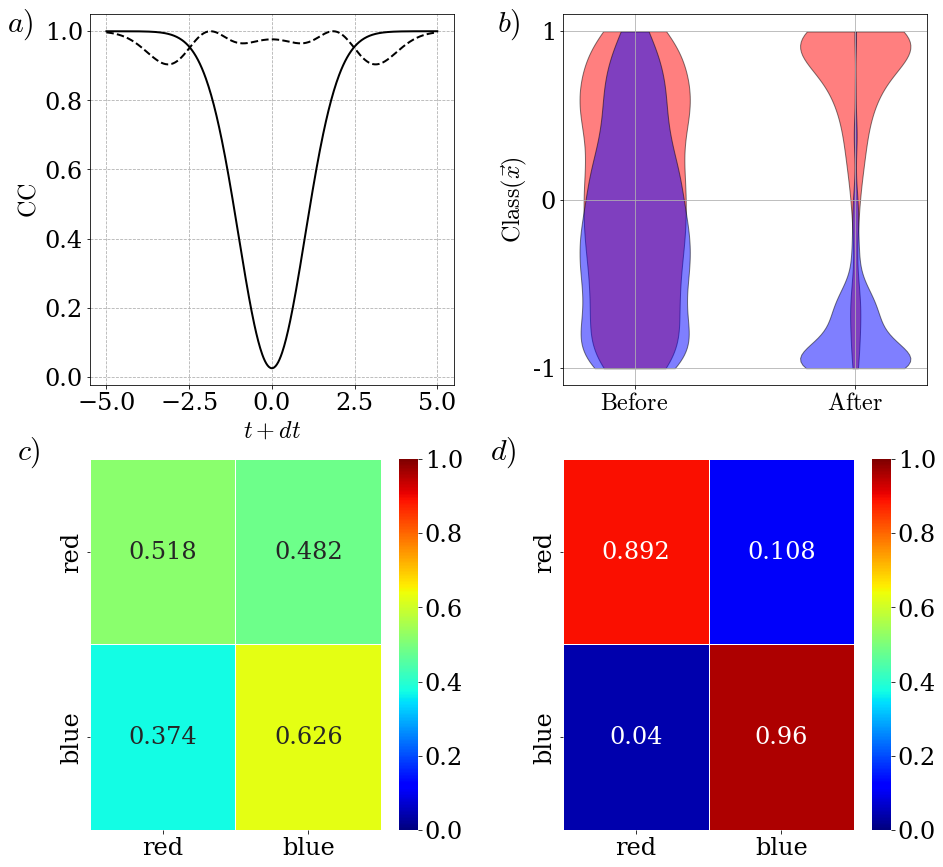

In [304]:
ap = 0.2
sz = 500
fs = 20
wid = 2

# Let's plot the data
fig2 = plt.figure(figsize=(15,15))

# Subplot 1
plt.subplot(2, 2, 1)


plt.plot(Dtvals, CCb, color='k', linewidth=2)
plt.plot(Dtvals, CCa, color='k', linewidth=2, linestyle='--')
plt.ylabel(r'$\mathrm{CC}$', fontsize=24)
plt.xlabel(r'$t+dt$', fontsize=24)

plt.grid(linestyle='--')

plt.text(-8.0, 1., r'$a)$', fontsize=30)

plt.subplot(2, 2, 2)


v1 = plt.violinplot(X0dipB, [-2], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipB, [-2], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

    
v1 = plt.violinplot(X0dipA, [2], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipA, [2], widths= wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
plt.xticks([])
plt.ylabel(r'$\mathrm{Class}(\vec{x})$', fontsize=24)
plt.xticks([-2, 2], [r'${\rm Before}$', r'${\rm After}$'], fontsize=24)


plt.yticks([0, 0.5, 1],[-1,0,1])

plt.grid()

plt.text(-4.5, 1., r'$b)$', fontsize=30)

plt.subplot(2, 2, 3)
ax1 = sns.heatmap(CMbefore,
                  xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                  cmap=cmap, 
                  annot=True, linewidth=0.5,
                  vmin=vmin, vmax=vmax,
                  fmt='.3g')

#ax1.title.set_text('CM before Training')
ax1.title.set_size(24)
#plt.xlabel('True Classifiction', fontsize = 15) # x-axis label with fontsize 15
#plt.ylabel('Calculated Classification', fontsize = 15) # y-axis label with fontsize 15

plt.text(-0.5, -0., r'$c)$', fontsize=30)

plt.subplot(2, 2, 4)
ax1 = sns.heatmap(CMafter,
                  xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                  cmap=cmap, 
                  annot=True, linewidth=0.5,
                  vmin=vmin, vmax=vmax,
                  fmt='.3g')

plt.text(-0.5, -0., r'$d)$', fontsize=30)

plt.subplots_adjust(wspace=0.3, hspace=0.2)

plt.show()

# fig2.savefig('results.png', bbox_inches='tight', dpi=200)